### 전처리 후 feature 대상으로 LGBM 학습  
(Developed from dacon_etri_base_mod3_1.ipynb)

In [1]:
from datetime import datetime

# 현재 날짜 및 시간 가져오기
now = datetime.now()
timestamp = now.strftime("%m%d_%H%M")  # 예: 0517_1530

# kmjng
# submission_folder = '/home/user/torch_ubuntu/lifelog-sleep-ictc-2025/minjeong/submission/'

# kmjng-nb
submission_folder = 'C:/Users/minjeong/Documents/my_env/env1/src/lifelog-sleep-ictc-2025/minjeong/submission'

submission_file = f'submission_final_mod3_1_{timestamp}.csv'

# kmjng
# base_folder =  '/home/user/torch_ubuntu/src/data/ETRI_lifelog_dataset'

# kmjng-nb
base_folder = 'C:/Users/minjeong/Documents/my_env/env1/src/data/ETRI_lifelog_dataset'

folder = '/ch2025_data_items'

data_dir = base_folder + folder 




In [2]:

import numpy as np 
import pandas as pd 
import glob 
import random 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns 
import ast 
import warnings
warnings.filterwarnings('ignore') 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
# import torch
import tensorflow as tf


In [3]:
# seed 고정 
SD = 42 
random.seed(SD) 
np.random.seed(SD) 
os.environ['PYTHONHASHSEED'] = str(SD)
tf.random.set_seed(SD)  # TensorFlow 시드 설정

# 파일 경로 설정 - VSCode 상대경로로 변경
# 실제 경로에 맞게 수정 필요


# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

In [4]:
# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mUsageStats, shape = (45197, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: wPedo, shape = (748100, 9)


In [5]:
# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 

In [6]:
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


In [7]:
# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (603493, 3)
⏳ mUsageStats 분리 중...
✅ mUsageStats_test → (16499, 3), mUsageStats_train → (28698, 3)
⏳ mWifi 분리 중...
✅ mWifi_test → (27467, 3), mWifi_train → (48869, 3)
⏳ wHr 분리 중...
✅ wHr_test → (143311, 3), wHr_train → (239607, 3)
⏳ wLight 분리 중...
✅ wLight_test → (233809, 3), wLight_train → (399932, 3)
⏳ wPedo 분리 중...
✅ wPedo_test → (288832, 9), wPedo_train → (459268, 9)


In [8]:
def process_mACStatus(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df = df.sort_values(['subject_id', 'timestamp']) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_charging'].values # 0/1 상태 
        times = group['timestamp'].values # 충전 상태 비율 
        ratio_charging = status.mean() 
        # 상태 전이 횟수 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        lengths = [] 
        current_len = 0 
        for val in status: 
            if val == 1: 
                current_len += 1 
            elif current_len > 0: 
                lengths.append(current_len) 
                current_len = 0 
        if current_len > 0: 
            lengths.append(current_len) 
        avg_charging_duration = np.mean(lengths) if lengths else 0 
        max_charging_duration = np.max(lengths) if lengths else 0 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'charging_ratio': ratio_charging, 
            'charging_transitions': transitions, 
            'avg_charging_duration': avg_charging_duration, 
            'max_charging_duration': max_charging_duration, 
        }) 
    return pd.DataFrame(results) 

mACStatus_df2 = process_mACStatus(mACStatus_df) 

In [9]:
def process_mActivity(df): 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        counts = group['m_activity'].value_counts(normalize=True) # 비율 
        row = {'subject_id': subj, 'date': date} 
        # 0~8 비율 저장 
        for i in range(9): 
            row[f'activity_{i}_ratio'] = counts.get(i, 0) 
        # 주요 활동 정보 
        row['dominant_activity'] = group['m_activity'].mode()[0] 
        row['num_unique_activities'] = group['m_activity'].nunique() 
        summary.append(row) 
    return pd.DataFrame(summary) 

mActivity_df2 = process_mActivity(mActivity_df) 

### Avitvity 전처리(2)

In [10]:
mActivity_df2.columns

Index(['subject_id', 'date', 'activity_0_ratio', 'activity_1_ratio',
       'activity_2_ratio', 'activity_3_ratio', 'activity_4_ratio',
       'activity_5_ratio', 'activity_6_ratio', 'activity_7_ratio',
       'activity_8_ratio', 'dominant_activity', 'num_unique_activities'],
      dtype='object')

In [11]:
mActivity_df2['activity_2_ratio'].value_counts(ascending=False)

activity_2_ratio
0    700
Name: count, dtype: int64

In [12]:
mActivity_df2.drop(columns=['activity_2_ratio', 'activity_5_ratio','activity_6_ratio'], axis=1, inplace=True) # 2번('bicycle'), 5번('tilting'), 6번 모두 0

In [21]:
mActivity_df2.head(3)

,subject_id,date,activity_0_ratio,activity_1_ratio,activity_3_ratio,activity_4_ratio,activity_7_ratio,activity_8_ratio,dominant_activity,num_unique_activities
0,id01,2024-06-26,0.125176,0.001406,0.672293,0.157525,0.043601,0.0,3,5
1,id01,2024-06-27,0.146528,0.000000,0.611111,0.220833,0.021528,0.0,3,4
2,id01,2024-06-28,0.111806,0.000694,0.861806,0.000694,0.025000,0.0,3,5


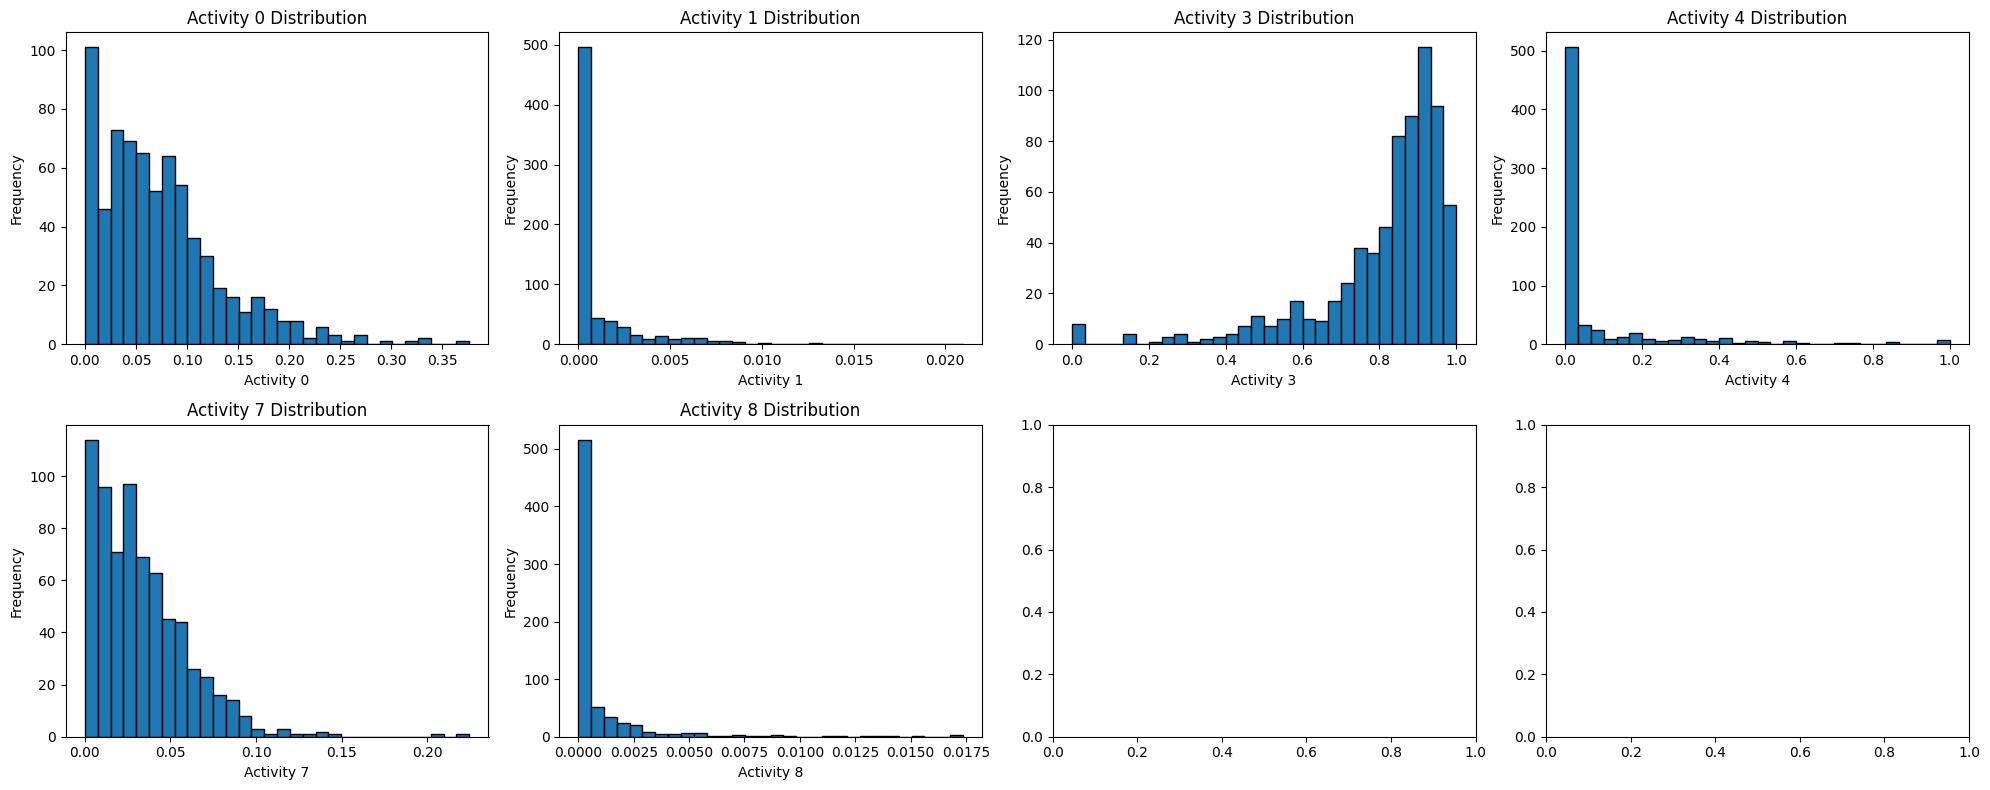

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import io
import numpy as np

df = mActivity_df2.copy()



# 히스토그램을 그릴 컬럼 이름 리스트 생성
activity_columns = [f'activity_{i}_ratio' for i in [0,1,3,4,7,8]]

# subplot 개수 계산
num_plots = len(activity_columns)

# subplot을 위한 행과 열 개수 결정 (예: 최대 4열로 배치)
num_cols = min(num_plots, 4)
num_rows = int(np.ceil(num_plots / num_cols))

# subplot 생성
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
axes = axes.flatten() # 2차원 axes 배열을 1차원으로 펼쳐서 인덱싱 용이하게 함

# 각 activity 컬럼에 대해 히스토그램 그리기
for i, col in enumerate(activity_columns):
    if i < num_plots:
        axes[i].hist(df[col], bins=30, edgecolor='black')
        axes[i].set_title(f'{col.replace("_ratio", "").replace("_", " ").title()} Distribution')
        axes[i].set_xlabel(col.replace("_ratio", "").replace("_", " ").title())
        axes[i].set_ylabel('Frequency')
    else:
        # 더 이상 그릴 그래프가 없으면 해당 subplot 숨기기
        fig.delaxes(axes[i])

# subplot 간 간격 조정
plt.tight_layout()

# 그래프 보여주기
plt.show()

https://shine2gether.tistory.com/entry/%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%82%AC%EC%9D%B4%EC%96%B8%EC%8A%A4-%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%A0%84%EC%B2%98%EB%A6%AC

In [ ]:
mActivity_df3 = mActivity_df2.copy()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
epsilon = 1e-6

# Activity 0: sqrt 변환 (Positive Skew 완화)
mActivity_df3['activity_0_ratio'] = np.sqrt(mActivity_df2['activity_0_ratio'])

# Activity 1: Arcsin 변환 (0에 몰린 비율 데이터)
mActivity_df3['activity_1_ratio'] = np.arcsin(np.sqrt(mActivity_df2['activity_1_ratio'].clip(0, 1))) # 0~1 범위 클리핑

# Activity 3:  (Negative Skew 완화)
max_3 = (mActivity_df2['activity_3_ratio']+1).max()
mActivity_df3['activity_3_ratio'] = np.sqrt(max_3 - mActivity_df2['activity_3_ratio'])

# Activity 4: sqrt 변환 (Positive Skew 완화)
mActivity_df3['activity_4_ratio'] = np.sqrt(mActivity_df2['activity_4_ratio'])

# Activity 7: sqrt 변환 (Positive Skew 완화)
mActivity_df3['activity_7_ratio'] = np.sqrt(mActivity_df2['activity_7_ratio'])

# Activity 8: Arcsin 변환 (0에 몰린 비율 데이터)
mActivity_df3['activity_8_ratio'] = np.arcsin(np.sqrt(mActivity_df2['activity_8_ratio'].clip(0, 1))) # 0~1 범위 클리핑

mActivity_df3.head(3)

,subject_id,date,activity_0_ratio,activity_1_ratio,activity_3_ratio,activity_4_ratio,activity_7_ratio,activity_8_ratio,dominant_activity,num_unique_activities
0,id01,2024-06-26,0.353802,0.037512,1.152262,0.396894,0.208807,0.0,3,5
1,id01,2024-06-27,0.382789,0.000000,1.178511,0.469929,0.146723,0.0,3,4
2,id01,2024-06-28,0.334373,0.026355,1.066862,0.026352,0.158114,0.0,3,5


In [39]:
mActivity_df3['activity_3_ratio'].describe()

count    700.000000
mean       1.086685
std        0.076759
min        1.000000
25%        1.036747
50%        1.063439
75%        1.112417
max        1.414214
Name: activity_3_ratio, dtype: float64

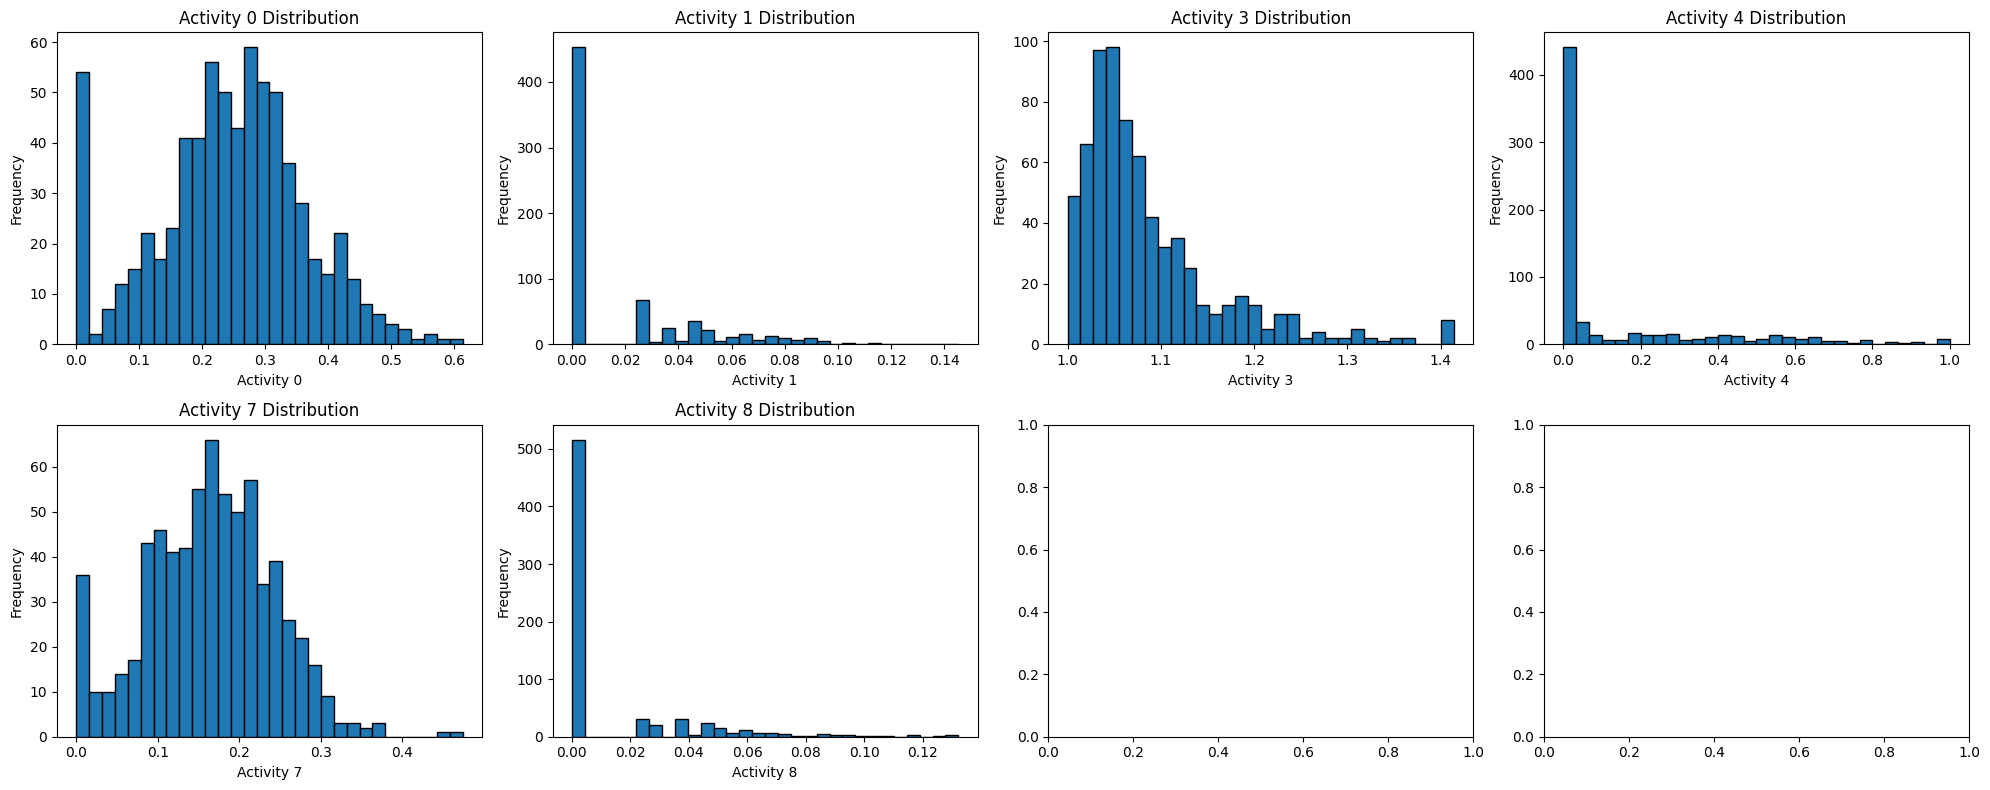

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import io
import numpy as np

df = mActivity_df3.copy()



# 히스토그램을 그릴 컬럼 이름 리스트 생성
activity_columns = [f'activity_{i}_ratio' for i in [0,1,3,4,7,8]]

# subplot 개수 계산
num_plots = len(activity_columns)

# subplot을 위한 행과 열 개수 결정 (예: 최대 4열로 배치)
num_cols = min(num_plots, 4)
num_rows = int(np.ceil(num_plots / num_cols))

# subplot 생성
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
axes = axes.flatten() # 2차원 axes 배열을 1차원으로 펼쳐서 인덱싱 용이하게 함

# 각 activity 컬럼에 대해 히스토그램 그리기
for i, col in enumerate(activity_columns):
    if i < num_plots:
        axes[i].hist(df[col], bins=30, edgecolor='black')
        axes[i].set_title(f'{col.replace("_ratio", "").replace("_", " ").title()} Distribution')
        axes[i].set_xlabel(col.replace("_ratio", "").replace("_", " ").title())
        axes[i].set_ylabel('Frequency')
    else:
        # 더 이상 그릴 그래프가 없으면 해당 subplot 숨기기
        fig.delaxes(axes[i])

# subplot 간 간격 조정
plt.tight_layout()

# 그래프 보여주기
plt.show()

### Ambience 

In [12]:
# 지정된 10개 라벨 
top_10_labels = [ 
    "Inside, small room", "Speech", "Silence", "Music", "Narration, monologue", 
    "Child speech, kid speaking", "Conversation", "Speech synthesizer", "Shout", "Babbling" 
] 

def process_mAmbience_top10(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    # 초기화 
    for label in top_10_labels + ['others']: 
        df[label] = 0.0 
    for idx, row in df.iterrows(): 
        parsed = ast.literal_eval(row['m_ambience']) if isinstance(row['m_ambience'], str) else row['m_ambience'] 
        others_prob = 0.0 
        for label, prob in parsed: 
            prob = float(prob) 
            if label in top_10_labels: 
                df.at[idx, label] = prob 
            else: 
                others_prob += prob 
        df.at[idx, 'others'] = others_prob 
    return df.drop(columns=['m_ambience']) 

mAmbience_df2= process_mAmbience_top10(mAmbience_df) 

In [13]:
def summarize_mAmbience_daily(df): 
    prob_cols = [col for col in df.columns if col not in ['subject_id', 'timestamp', 'date']] 
    # 하루 단위로 평균값 요약 
    daily_summary = df.groupby(['subject_id', 'date'])[prob_cols].mean().reset_index() 
    return daily_summary 

mAmbience_df2 = summarize_mAmbience_daily(mAmbience_df2) 


In [15]:
def process_mBle(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        entry = ast.literal_eval(row['m_ble']) if isinstance(row['m_ble'], str) else row['m_ble'] 
        rssi_list = [] 
        class_0_cnt = 0 
        class_other_cnt = 0 
        for device in entry: 
            try: 
                rssi = int(device['rssi']) 
                rssi_list.append(rssi) 
                if str(device['device_class']) == '0': 
                    class_0_cnt += 1 
                else: 
                    class_other_cnt += 1 
            except: 
                continue # malformed record 
        feature = { 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'device_class_0_cnt': class_0_cnt, 
            'device_class_others_cnt': class_other_cnt, 
            'device_count': len(rssi_list), 
            'rssi_mean': np.mean(rssi_list) if rssi_list else np.nan, 
            'rssi_min': np.min(rssi_list) if rssi_list else np.nan, 
            'rssi_max': np.max(rssi_list) if rssi_list else np.nan, 
        } 
        features.append(feature) 
    return pd.DataFrame(features) 

In [16]:
def summarize_mBle_daily(df): 
    # row 단위 BLE feature 추출 
    df = process_mBle(df) 
    # 하루 단위로 cnt 합치기 
    grouped = df.groupby(['subject_id', 'date']).agg({ 
        'device_class_0_cnt': 'sum', 
        'device_class_others_cnt': 'sum', 
        'rssi_mean': 'mean', 
        'rssi_min': 'min', 
        'rssi_max': 'max', 
    }).reset_index() 
    # 총합 구해서 비율 계산 
    total_cnt = grouped['device_class_0_cnt'] + grouped['device_class_others_cnt'] 
    grouped['device_class_0_ratio'] = grouped['device_class_0_cnt'] / total_cnt.replace(0, np.nan) 
    grouped['device_class_others_ratio'] = grouped['device_class_others_cnt'] / total_cnt.replace(0, np.nan) 
    # 필요 없는 원래 cnt 컬럼 제거 
    grouped.drop(columns=['device_class_0_cnt', 'device_class_others_cnt'], inplace=True) 
    return grouped 

mBle_df2 = summarize_mBle_daily(mBle_df) 

In [17]:
def process_mGps(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for idx, row in df.iterrows(): 
        gps_list = ast.literal_eval(row['m_gps']) if isinstance(row['m_gps'], str) else row['m_gps'] 
        altitudes = [] 
        latitudes = [] 
        longitudes = [] 
        speeds = [] 
        for entry in gps_list: 
            try: 
                altitudes.append(float(entry['altitude'])) 
                latitudes.append(float(entry['latitude'])) 
                longitudes.append(float(entry['longitude'])) 
                speeds.append(float(entry['speed'])) 
            except: 
                continue 
        features.append({ 
            'subject_id': row['subject_id'], 
            'date': row['date'], 
            'altitude_mean': np.mean(altitudes) if altitudes else np.nan, 
            'latitude_std': np.std(latitudes) if latitudes else np.nan, 
            'longitude_std': np.std(longitudes) if longitudes else np.nan, 
            'speed_mean': np.mean(speeds) if speeds else np.nan, 
            'speed_max': np.max(speeds) if speeds else np.nan, 
            'speed_std': np.std(speeds) if speeds else np.nan, 
        }) 
    return pd.DataFrame(features) 

In [18]:
m_Gps_df2 = process_mGps(mGps_df) 
m_Gps_df2 = m_Gps_df2.groupby(['subject_id', 'date']).agg({ 
    'altitude_mean': 'mean', 
    'latitude_std': 'mean', 
    'longitude_std': 'mean', 
    'speed_mean': 'mean', 
    'speed_max': 'max', 
    'speed_std': 'mean' 
}).reset_index() 

In [19]:
def process_mLight(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour 
    # 밤(22~05시), 낮(06~21시) 구분 
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6) 
    # 하루 단위 요약 
    daily = df.groupby(['subject_id', 'date']).agg( 
        light_mean=('m_light', 'mean'), 
        light_std=('m_light', 'std'), 
        light_max=('m_light', 'max'), 
        light_min=('m_light', 'min'), 
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()), 
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()), 
        light_night_ratio=('is_night', 'mean') # 밤 시간 측정 비율 
    ).reset_index() 
    return daily 

mLight_df2 = process_mLight(mLight_df) 

In [20]:
def process_mScreenStatus(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        status = group['m_screen_use'].values 
        ratio_on = status.mean() 
        transitions = (status[1:] != status[:-1]).sum() 
        # 연속된 1 상태 길이들 
        durations = [] 
        current = 0 
        for val in status: 
            if val == 1: 
                current += 1 
            elif current > 0: 
                durations.append(current) 
                current = 0 
        if current > 0: 
            durations.append(current) 
        features.append({ 
            'subject_id': subj, 
            'date': date, 
            'screen_on_ratio': ratio_on, 
            'screen_on_transitions': transitions, 
            'screen_on_duration_avg': np.mean(durations) if durations else 0, 
            'screen_on_duration_max': np.max(durations) if durations else 0, 
        }) 
    return pd.DataFrame(features) 

mScreenStatus_df2 = process_mScreenStatus(mScreenStatus_df) 


In [21]:
top_apps = [ 
    'One UI 홈', '카카오톡', '시스템 UI', 'NAVER', '캐시워크', 
    '성경일독Q', 'YouTube', '통화', '메시지', '타임스프레드', 'Instagram'
] 

def process_mUsageStats(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        app_time = {app: 0 for app in top_apps} 
        others_time = 0 
        for row in group['m_usage_stats']: 
            parsed = ast.literal_eval(row) if isinstance(row, str) else row 
            for entry in parsed: 
                app = entry.get('app_name') 
                time = entry.get('total_time', 0) 
                if app in top_apps: 
                    app_time[app] += int(time) 
                else: 
                    others_time += int(time) 
        feature = { 
            'subject_id': subj, 
            'date': date, 
            'others_time': others_time 
        } 
        # 각 앱별 컬럼 추가 
        feature.update({f'{app}_time': app_time[app] for app in top_apps}) 
        features.append(feature) 
    return pd.DataFrame(features) 

mUsageStats_df2 = process_mUsageStats(mUsageStats_df) 

In [22]:

def process_mWifi(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        rssi_all = [] 
        for row in group['m_wifi']: 
            parsed = ast.literal_eval(row) if isinstance(row, str) else row 
            for ap in parsed: 
                try: 
                    rssi = int(ap['rssi']) 
                    rssi_all.append(rssi) 
                except: 
                    continue 
        results.append({ 
            'subject_id': subj, 
            'date': date, 
            'wifi_rssi_mean': np.mean(rssi_all) if rssi_all else np.nan, 
            'wifi_rssi_min': np.min(rssi_all) if rssi_all else np.nan, 
            'wifi_rssi_max': np.max(rssi_all) if rssi_all else np.nan, 
            'wifi_detected_cnt': len(rssi_all) 
        }) 
    return pd.DataFrame(results) 

mWifi_df2 = process_mWifi(mWifi_df) 

In [23]:

def get_time_block(hour): 
    if 0 <= hour < 6: 
        return 'early_morning' 
    elif 6 <= hour < 12: 
        return 'morning' 
    elif 12 <= hour < 18: 
        return 'afternoon' 
    else: 
        return 'evening' 

def process_wHr_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            hr_all = [] 
            for row in block_group['heart_rate']: 
                parsed = ast.literal_eval(row) if isinstance(row, str) else row 
                hr_all.extend([int(h) for h in parsed if h is not None]) 
            if not hr_all: 
                continue 
            above_100 = [hr for hr in hr_all if hr > 100] 
            block_stats[f'hr_{block}_mean'] = np.mean(hr_all) 
            block_stats[f'hr_{block}_std'] = np.std(hr_all) 
            block_stats[f'hr_{block}_max'] = np.max(hr_all) 
            block_stats[f'hr_{block}_min'] = np.min(hr_all) 
            block_stats[f'hr_{block}_above_100_ratio'] = len(above_100) / len(hr_all) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wHr_df2 = process_wHr_by_timeblock(wHr_df) 

In [24]:

def process_wLight_by_timeblock(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['block'] = df['timestamp'].dt.hour.map(get_time_block) 
    results = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        block_stats = {'subject_id': subj, 'date': date} 
        for block, block_group in group.groupby('block'): 
            lux = block_group['w_light'].dropna().values 
            if len(lux) == 0: 
                continue 
            block_stats[f'wlight_{block}_mean'] = np.mean(lux) 
            block_stats[f'wlight_{block}_std'] = np.std(lux) 
            block_stats[f'wlight_{block}_max'] = np.max(lux) 
            block_stats[f'wlight_{block}_min'] = np.min(lux) 
        results.append(block_stats) 
    return pd.DataFrame(results) 

wLight_df2 = process_wLight_by_timeblock(wLight_df)

In [25]:
def process_wPedo(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    summary = df.groupby(['subject_id', 'date']).agg({ 
        'step': 'sum', 
        'step_frequency': 'mean', 
        'distance': 'sum', 
        'speed': ['mean', 'max'], 
        'burned_calories': 'sum' 
    }).reset_index() 
    # 컬럼 이름 정리 
    summary.columns = ['subject_id', 'date', 'step_sum', 'step_frequency_mean', 'distance_sum', 'speed_mean', 'speed_max', 'burned_calories_sum'] 
    return summary 

wPedo_df2 = process_wPedo(wPedo_df) 

In [26]:

from functools import reduce 
df_list = [ 
    mACStatus_df2, 
    mActivity_df2, 
    mAmbience_df2, 
    mBle_df2, 
    m_Gps_df2, 
    mLight_df2, 
    mScreenStatus_df2, 
    mUsageStats_df2, 
    mWifi_df2, 
    wHr_df2, 
    wLight_df2, 
    wPedo_df2 
] 

merged_df = reduce(lambda left, right: pd.merge(left, right, on=['subject_id', 'date'], how='outer'), df_list) 


In [27]:

# metrics_train의 lifelog_date → datetime.date 형으로 변환 
metrics_train['lifelog_date'] = pd.to_datetime(metrics_train['lifelog_date']).dt.date 

# merged_df의 date도 변환 
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date 

# 1. date 기준 정렬을 위해 metrics_train의 lifelog_date -> date로 맞추기 
metrics_train_renamed = metrics_train.rename(columns={'lifelog_date': 'date'}) 

# 2. train_df: metrics_train과 일치하는 (subject_id, date) → 라벨 포함 
train_df = pd.merge(metrics_train_renamed, merged_df, on=['subject_id', 'date'], how='inner') 

# 3. test_df: metrics_train에 없는 (subject_id, date) 
merged_keys = merged_df[['subject_id', 'date']] 
train_keys = metrics_train_renamed[['subject_id', 'date']] 
test_keys = pd.merge(merged_keys, train_keys, on=['subject_id', 'date'], how='left', indicator=True) 
test_keys = test_keys[test_keys['_merge'] == 'left_only'].drop(columns=['_merge']) 
test_df = pd.merge(test_keys, merged_df, on=['subject_id', 'date'], how='left') 


In [28]:

# ✅ 타겟 리스트 
targets_binary = ['Q1', 'Q2', 'Q3', 'S2', 'S3'] 
target_multiclass = 'S1' 

# ✅ feature 준비 
X = train_df.drop(columns=['subject_id', 'sleep_date', 'date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']) 
X.fillna(0, inplace=True) # 결측값 처리 

test_X = test_df.drop(columns=['subject_id', 'date']) 
test_X.fillna(0, inplace=True) 


In [ ]:

# 컬럼 이름에서 특수 문자 제거/변환 
def sanitize_column_names(df): 
    df.columns = ( 
        df.columns 
        .str.replace(r"[^\w]", "_", regex=True) # 특수문자 → _ 
        .str.replace(r"__+", "_", regex=True) # 연속된 _ 제거 
        .str.strip("_") # 앞뒤 _ 제거 
    ) 
    return df 

# 모든 입력에 적용 
X = sanitize_column_names(X) 
test_X = sanitize_column_names(test_X) 

### 모델링 시작 

In [55]:
# 결과 저장 
# 그룹별 중요 특성 선택
important_features = [
    # 스크린 관련 특성
    'screen_on_ratio', 'screen_on_duration_avg', 'screen_on_duration_max',
    
    # 와이파이 신호 관련 특성
    'wifi_rssi_max', 'wifi_rssi_mean', 'wifi_detected_cnt',
    
    # 활동 관련 특성
    'activity_3_ratio', 'activity_4_ratio',
    
    # 충전 관련 특성
    'charging_ratio', 'max_charging_duration', 'avg_charging_duration',
    
    # 신호 관련 특성
    'rssi_mean',
    
    # 빛 관련 특성
    'light_night_mean', 'light_max', 'light_std',
    
    # 위치/움직임 관련 특성
    'altitude_mean', 'speed_max_x',
    
    # 앱 사용 관련 특성
    '메시지_time', 'others_time', 'Narration_monologue'
]

# 선택된 특성만으로 데이터셋 구성
X_selected = X[important_features]
test_X_selected = test_X[important_features]



In [ ]:
# LightGBM 라이브러리 임포트
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# GridSearch를 위한 교차 검증 설정
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# LightGBM 기본 파라미터 설정
lgbm_params = {
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

# 이진 분류 모델 성능 향상을 위한 그리드 서치 파라미터
binary_param_grid = {
    'learning_rate': [0.01, 0.03],
    'n_estimators': [500, 1000],
    'num_leaves': [50, 100],
    'max_depth': [-1, 5],
    'min_child_samples': [10, 30],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1],
}

# 다중 분류 모델 성능 향상을 위한 그리드 서치 파라미터
multi_param_grid = {
    'learning_rate': [0.01, 0.03],
    'n_estimators': [500, 1000],
    'num_leaves': [50, 100],
    'max_depth': [-1, 5],
    'min_child_samples': [10, 30],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1],
}

In [64]:
# 이진 분류 모델 최적화 및 학습
binary_preds_selected = {}
for col in targets_binary:
    y = train_df[col]
    
    # 이진 분류용 모델 설정
    binary_model = LGBMClassifier(objective='binary', **lgbm_params)
    
    # 그리드 서치로 최적 파라미터 찾기
    grid_search = GridSearchCV(
        estimator=binary_model,
        param_grid=binary_param_grid,
        scoring='f1',  # 또는 'roc_auc', 'precision', 'recall' 등 문제에 적합한 지표 선택
        cv=cv,
        verbose=1,
        n_jobs=-1
    )
    
    print(f"\n{col} 이진 분류 모델 최적화 중...")
    grid_search.fit(X_selected, y)
    
    print(f"최적 파라미터: {grid_search.best_params_}")
    print(f"최고 점수: {grid_search.best_score_:.4f}")
    
    # 최적 모델로 예측
    best_model = grid_search.best_estimator_
    binary_preds_selected[col] = best_model.predict(test_X_selected)

# 다중 분류 (S1) 모델 최적화 및 학습
y_multi = train_df['S1']
n_classes = len(y_multi.unique())

# 다중 분류용 모델 설정
multiclass_model = LGBMClassifier(objective='multiclass', num_class=n_classes, **lgbm_params)

# 그리드 서치로 최적 파라미터 찾기
grid_search_multi = GridSearchCV(
    estimator=multiclass_model,
    param_grid=multi_param_grid,
    scoring='f1_macro',  # 다중 분류에서는 macro 평균 사용
    cv=cv,
    verbose=1,
    n_jobs=-1
)

print("\nS1 다중 분류 모델 최적화 중...")
grid_search_multi.fit(X_selected, y_multi)

print(f"최적 파라미터: {grid_search_multi.best_params_}")
print(f"최고 점수: {grid_search_multi.best_score_:.4f}")

# 최적 모델로 예측
best_multi_model = grid_search_multi.best_estimator_
multiclass_pred_selected = best_multi_model.predict(test_X_selected)

# # 이진 분류
# binary_preds_selected = {}
# for col in targets_binary:
#     y = train_df[col]
#     # 이진 분류용 파라미터 조정
#     binary_params = lgbm_params.copy()
#     binary_params['objective'] = 'binary'
    
#     model = LGBMClassifier(**binary_params)
#     model.fit(X_selected, y)
#     binary_preds_selected[col] = model.predict(test_X_selected)

# # 다중 분류 (S1)
# y_multi = train_df['S1']
# # 다중 분류용 파라미터 설정 (클래스 수 추가)
# multiclass_params = lgbm_params.copy()
# multiclass_params['num_class'] = len(y_multi.unique())

# model_s1_selected = LGBMClassifier(**multiclass_params)
# model_s1_selected.fit(X_selected, y_multi)
# multiclass_pred_selected = model_s1_selected.predict(test_X_selected)


Q1 이진 분류 모델 최적화 중...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
최적 파라미터: {'learning_rate': 0.01, 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 500, 'num_leaves': 50}
최고 점수: 0.5735

Q2 이진 분류 모델 최적화 중...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
최적 파라미터: {'learning_rate': 0.03, 'max_depth': -1, 'min_child_samples': 10, 'n_estimators': 1000, 'num_leaves': 50}
최고 점수: 0.6602

Q3 이진 분류 모델 최적화 중...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
최적 파라미터: {'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 50}
최고 점수: 0.6849

S2 이진 분류 모델 최적화 중...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
최적 파라미터: {'learning_rate': 0.01, 'max_depth': -1, 'min_child_samples': 30, 'n_estimators': 500, 'num_leaves': 50}
최고 점수: 0.7479

S3 이진 분류 모델 최적화 중...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
최적 파라미터: {'learning_rate': 0.03, 'max_depth': 5, 'min_child_samples': 30,

In [65]:
# 검증 데이터에 대한 성능 평가
X_train_sel, X_val_sel, y_train, y_val = train_test_split(
    X_selected, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

# 최적 파라미터를 사용하여 검증용 모델 학습
eval_model_sel = LGBMClassifier(**grid_search_multi.best_params_)
eval_model_sel.fit(X_train_sel, y_train)

# 예측 및 평가
y_pred_sel = eval_model_sel.predict(X_val_sel)

print("\n===== LightGBM 최적화 모델 평가 (S1) =====")
print(classification_report(y_val, y_pred_sel))
print("\n혼동 행렬:")
print(confusion_matrix(y_val, y_pred_sel))

# # 성능 평가 (원본 모델과 비교)
# # 검증 데이터 분할
# X_train_sel, X_val_sel, y_train, y_val = train_test_split(
#     X_selected, y_multi, test_size=0.2, random_state=42, stratify=y_multi
# )

# # 평가용 모델 학습
# eval_model_sel = LGBMClassifier(**multiclass_params)
# eval_model_sel.fit(X_train_sel, y_train)

# # 예측 및 평가
# y_pred_sel = eval_model_sel.predict(X_val_sel)

# print("\n===== LightGBM 그룹 기반 특성 선택 모델 평가 (S1) =====")
# print(classification_report(y_val, y_pred_sel))


===== LightGBM 최적화 모델 평가 (S1) =====
              precision    recall  f1-score   support

           0       0.41      0.38      0.39        29
           1       0.52      0.69      0.59        45
           2       0.33      0.06      0.11        16

    accuracy                           0.48        90
   macro avg       0.42      0.38      0.36        90
weighted avg       0.45      0.48      0.44        90


혼동 행렬:
[[11 18  0]
 [12 31  2]
 [ 4 11  1]]


In [ ]:

# # 특성 중요도 추출 및 데이터프레임 생성
# importances = model_s1_selected.feature_importances_
# feature_importance = pd.DataFrame({
#     'feature': important_features,
#     'importance': importances
# })
# # 중요도 기준 내림차순 정렬
# feature_importance = feature_importance.sort_values('importance', ascending=False)

# # 시각화
# plt.figure(figsize=(10, 10))
# sns.barplot(x='importance', y='feature', data=feature_importance)
# plt.title('Feature Importance')
# plt.tight_layout()
# plt.savefig('feature_importance.png')
# plt.show()

In [ ]:
# # 이진 분류 학습 
# for col in targets_binary: 
#     y = train_df[col] 
#     model = RandomForestClassifier(**common_params) 
#     model.fit(X, y) 
#     binary_preds[col] = model.predict(test_X) # 🔥 확률X, 클래스 직접 예측 

# # 다중 분류 학습 (S1) 
# y_multi = train_df['S1'] 
# model_s1 = RandomForestClassifier(**common_params) 
# model_s1.fit(X, y_multi) 
# multiclass_pred = model_s1.predict(test_X) # 🔥 클래스 직접 예측 

# # importance 출력
# feature_importance = pd.DataFrame({ 
#     'feature': X.columns, 
#     'importance': model_s1.feature_importances_ 
# }).sort_values('importance', ascending=False) 

# # 시각화 
# plt.figure(figsize=(10, 10)) 
# sns.barplot(x='importance', y='feature', data=feature_importance) 
# plt.title('Feature Importance')
# plt.tight_layout()
# plt.savefig('feature_importance.png')
# plt.show()

In [66]:
# sample 기반 제출 포맷 가져오기
submission_final = sample_submission[['subject_id', 'sleep_date', 'lifelog_date']].copy()

# lifelog_date 기준으로 string → date 형식 통일
submission_final['lifelog_date'] = pd.to_datetime(submission_final['lifelog_date']).dt.date

# ID 만들기 (submission에서 예측한 결과와 연결하기 위해)
submission_final['ID'] = submission_final['subject_id'] + '_' + submission_final['lifelog_date'].astype(str)

In [67]:

# 예측 결과 연결할 수 있도록 동일한 순서로 정렬
# 보통 예측 결과는 test_df 기준이므로 정렬 보장되어야 함
assert len(submission_final) == len(multiclass_pred_selected) # shape 체크

# 다중 분류 예측 붙이기
submission_final['S1'] = multiclass_pred_selected

# 이진 분류 결과 붙이기
for col in ['Q1', 'Q2', 'Q3', 'S2', 'S3']:
    submission_final[col] = binary_preds_selected[col].astype(int) # 확률 아닌 class 예측


In [68]:

# 최종 제출 형식 정렬
submission_final = submission_final[['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1', 'S2', 'S3']]

# 저장
submission_final.to_csv(submission_folder + submission_file, index=False)

# VSCode에서는 files.download()가 작동하지 않으므로 대체

print(f"✅ 제출 파일이 저장되었습니다: {os.path.abspath(submission_file)}")

✅ 제출 파일이 저장되었습니다: c:\Users\KTL\Desktop\submission_final_mod3_0519_1554.csv


In [ ]:

# # 모델 저장 (추가 기능)
# import joblib

# # 모델 저장 디렉토리 생성
# os.makedirs('models', exist_ok=True)

# # 이진 분류 모델 저장
# for col in targets_binary:
#     joblib.dump(binary_preds[col], f'models/binary_model_{col}.pkl')
#     print(f"✅ 저장 완료: binary_model_{col}.pkl")

# # 다중 분류 모델 저장
# joblib.dump(model_s1, 'models/multiclass_model_S1.pkl')
# print(f"✅ 저장 완료: multiclass_model_S1.pkl")

✅ 저장 완료: binary_model_Q1.pkl
✅ 저장 완료: binary_model_Q2.pkl
✅ 저장 완료: binary_model_Q3.pkl
✅ 저장 완료: binary_model_S2.pkl
✅ 저장 완료: binary_model_S3.pkl
✅ 저장 완료: multiclass_model_S1.pkl


In [ ]:
 
# # 결과 요약 - 특성 중요도 상위 20개 표시
# print("\n===== 주요 특성 중요도 (상위 20개) =====")
# print(feature_importance.head(20))

# # 모델 평가 (검증 데이터가 있는 경우)
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix

# # 검증용 데이터 분리
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y_multi, test_size=0.2, random_state=42, stratify=y_multi
# )


===== 주요 특성 중요도 (상위 20개) =====
                   feature  importance
44         screen_on_ratio    0.021762
48             others_time    0.020832
46  screen_on_duration_avg    0.020828
7         activity_3_ratio    0.017365
62           wifi_rssi_max    0.016938
60          wifi_rssi_mean    0.016477
3    max_charging_duration    0.016160
26               rssi_mean    0.015765
0           charging_ratio    0.015758
8         activity_4_ratio    0.015606
41        light_night_mean    0.015580
47  screen_on_duration_max    0.015548
39               light_max    0.015141
2    avg_charging_duration    0.014409
31           altitude_mean    0.013876
38               light_std    0.013854
63       wifi_detected_cnt    0.013744
35             speed_max_x    0.013394
57                메시지_time    0.013303
19     Narration_monologue    0.013183


In [ ]:

# # 평가용 모델 학습
# eval_model = RandomForestClassifier(**common_params)
# eval_model.fit(X_train, y_train)

# # 예측 및 평가
# y_pred = eval_model.predict(X_val)
# print("\n===== 다중 분류 모델 평가 (S1) =====")
# print(classification_report(y_val, y_pred))


===== 다중 분류 모델 평가 (S1) =====
              precision    recall  f1-score   support

           0       0.44      0.24      0.31        29
           1       0.52      0.84      0.64        45
           2       1.00      0.06      0.12        16

    accuracy                           0.51        90
   macro avg       0.65      0.38      0.36        90
weighted avg       0.58      0.51      0.44        90



In [ ]:

# # 이진 분류 모델 평가
# for col in targets_binary:
#     y_binary = train_df[col]
#     X_train, X_val, y_train, y_val = train_test_split(
#         X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
#     )
    
#     eval_model = RandomForestClassifier(**common_params)
#     eval_model.fit(X_train, y_train)
    
#     y_pred = eval_model.predict(X_val)
#     print(f"\n===== 이진 분류 모델 평가 ({col}) =====")
#     print(classification_report(y_val, y_pred))

# print("\n✅ 모든 과정이 완료되었습니다!")


===== 이진 분류 모델 평가 (Q1) =====
              precision    recall  f1-score   support

           0       0.59      0.58      0.58        45
           1       0.59      0.60      0.59        45

    accuracy                           0.59        90
   macro avg       0.59      0.59      0.59        90
weighted avg       0.59      0.59      0.59        90


===== 이진 분류 모델 평가 (Q2) =====
              precision    recall  f1-score   support

           0       0.49      0.54      0.51        39
           1       0.62      0.57      0.59        51

    accuracy                           0.56        90
   macro avg       0.55      0.55      0.55        90
weighted avg       0.56      0.56      0.56        90


===== 이진 분류 모델 평가 (Q3) =====
              precision    recall  f1-score   support

           0       0.50      0.28      0.36        36
           1       0.63      0.81      0.71        54

    accuracy                           0.60        90
   macro avg       0.56      0.55     